<a href="https://colab.research.google.com/github/sital3/Analysing-Algerian-Fire-Forest-Pattern/blob/main/aqi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup + Dataset Download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install numpy pandas scikit-learn matplotlib seaborn xgboost torch torchvision joblib fastapi uvicorn python-multipart optuna shap kaggle
!pip install git+https://github.com/lucidrains/perceiver-pytorch.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.5 MB/s eta 0:00:00
  Cloning https://github.com/lucidrains/perceiver-pytorch.git to /tmp/pip-req-build-e7dnwxdq
  Running command git clone --filter=blob:none --quiet https://github.com/lucidrains/perceiver-pytorch.git /tmp/pip-req-build-e7dnwxdq
  Resolved https://github.com/lucidrains/perceiver-pytorch.git to commit c3d505a997a6e3521e83d7d2bf57cb8b62e3fbd6
  Preparing metadata (setup.py) ... done
  Created wheel for perceiver-pytorch: filename=perceiver_pytorch-0.8.8-py3-none-any.whl size=12508 sha256=f5d045748e27f92d804ac42fbf0f92b8d266babfda2643aa28b1f6b7b32df519
  Stored in directory: /tmp/pip-ephem-wheel-cache-0emn59f8/wheels/a2/5b/a1/0a387fab36778c004c84248a9d26a59fb9eef5725a92915884
Successfully built perceiver-pytorch


In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samairajyala","key":"77e888623be039352cf4d7808d3acab1"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d rohanrao/air-quality-data-in-india -p /content/data --unzip


Dataset URL: https://www.kaggle.com/datasets/rohanrao/air-quality-data-in-india
License(s): CC0-1.0
 82% 60.0M/72.9M [00:00<00:00, 243MB/s]
100% 72.9M/72.9M [00:00<00:00, 269MB/s]


#  Preprocessing

In [5]:
import pandas as pd

# apna dataset load karo
df = pd.read_csv("/content/data/city_day.csv")   # Kaggle dataset ke andar "city_day.csv" hota hai

print(df.head())
print(df.columns)


        City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad  2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad  2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN  
3   36.08     4.43    10.14    1.00  NaN        NaN  
4   39.31     7.01    18.89    2.78  NaN        NaN  
Index(['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')


In [6]:
city = "Delhi"
df_city = df[df['City'] == city].copy()
print(df_city.head())


        City        Date   PM2.5    PM10     NO    NO2     NOx     NH3     CO  \
10229  Delhi  2015-01-01  313.22  607.98  69.16  36.39  110.59   33.85  15.20   
10230  Delhi  2015-01-02  186.18  269.55  62.09  32.87   88.14   31.83   9.54   
10231  Delhi  2015-01-03   87.18  131.90  25.73  30.31   47.95   69.55  10.61   
10232  Delhi  2015-01-04  151.84  241.84  25.01  36.91   48.62  130.36  11.54   
10233  Delhi  2015-01-05  146.60  219.13  14.01  34.92   38.25  122.88   9.20   

        SO2     O3  Benzene  Toluene  Xylene    AQI AQI_Bucket  
10229  9.25  41.68    14.36    24.86    9.84  472.0     Severe  
10230  6.65  29.97    10.55    20.09    4.29  454.0     Severe  
10231  2.65  19.71     3.91    10.23    1.99  143.0   Moderate  
10232  4.63  25.36     4.26     9.71    3.34  319.0  Very Poor  
10233  3.33  23.20     2.80     6.21    2.96  325.0  Very Poor  


In [7]:
import pandas as pd

# Delhi filter already kar liya tha → ab waha se continue
# Agar tumne fresh start kiya hai to:
# df_city = df[df['City'] == "Delhi"].copy()

# ✅ Step 1: Convert Date if still column
if "Date" in df_city.columns:
    df_city['Date'] = pd.to_datetime(df_city['Date'], errors='coerce')
    df_city = df_city.set_index('Date')

# ✅ Step 2: Keep only numeric columns
df_city = df_city.select_dtypes(include=['float64','int64'])

# ✅ Step 3: Resample daily
df_city = df_city.resample('1D').mean()

# ✅ Step 4: Interpolate missing
df_city = df_city.interpolate(limit=5)

# ✅ Step 5: Check results
print(df_city.isna().sum())
df_city.head()


PM2.5        0
PM10        55
NO           0
NO2          0
NOx          0
NH3          0
CO           0
SO2         99
O3          76
Benzene      0
Toluene      0
Xylene     756
AQI          0
dtype: int64


,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
Date,,,,,,,,,,,,,
2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0
2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,4.29,454.0
2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,1.99,143.0
2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,3.34,319.0
2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,2.96,325.0


In [8]:
df.drop('Xylene', axis=1)


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,Visakhapatnam,2020-06-27,15.02,50.94,7.68,25.06,19.54,12.47,0.47,8.55,23.30,2.24,12.07,41.0,Good
29527,Visakhapatnam,2020-06-28,24.38,74.09,3.42,26.06,16.53,11.99,0.52,12.72,30.14,0.74,2.21,70.0,Satisfactory
29528,Visakhapatnam,2020-06-29,22.91,65.73,3.45,29.53,18.33,10.71,0.48,8.42,30.96,0.01,0.01,68.0,Satisfactory
29529,Visakhapatnam,2020-06-30,16.64,49.97,4.05,29.26,18.80,10.03,0.52,9.84,28.30,0.00,0.00,54.0,Satisfactory


# Feature Engineering

In [9]:
import numpy as np

# ---- Time Features ----
df_city['dayofweek'] = df_city.index.dayofweek
df_city['month'] = df_city.index.month
df_city['dayofyear'] = df_city.index.dayofyear

# Cyclic encoding for seasonality
df_city['day_sin'] = np.sin(2*np.pi*df_city['dayofyear']/365)
df_city['day_cos'] = np.cos(2*np.pi*df_city['dayofyear']/365)

# ---- Lag Features ----
for lag in [1, 2, 3, 7, 14, 30]:
    df_city[f'aqi_lag_{lag}'] = df_city['AQI'].shift(lag)

# ---- Rolling Averages ----
df_city['aqi_roll_7'] = df_city['AQI'].rolling(7).mean()
df_city['aqi_roll_30'] = df_city['AQI'].rolling(30).mean()

# Drop NaNs created by shifting/rolling
df_city = df_city.dropna()

# ---- Save Final Dataset ----
df_city.to_csv("/content/data/processed_delhi.csv")
print("✅ Processed dataset saved at /content/data/processed_delhi.csv")

df_city.head()


✅ Processed dataset saved at /content/data/processed_delhi.csv


,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,...,day_sin,day_cos,aqi_lag_1,aqi_lag_2,aqi_lag_3,aqi_lag_7,aqi_lag_14,aqi_lag_30,aqi_roll_7,aqi_roll_30
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-31,158.59,207.06,30.67,41.36,57.77,67.66,8.70,5.03,17.51,4.36,...,0.508671,0.860961,345.0,327.0,295.0,324.0,360.0,472.0,320.571429,337.966667
2015-02-01,211.59,371.05,57.56,58.17,93.17,96.69,13.08,9.90,23.28,6.65,...,0.523416,0.852078,334.0,345.0,327.0,333.0,370.0,454.0,324.142857,334.766667
2015-02-02,163.64,219.84,13.70,37.25,39.34,84.49,10.59,5.31,28.38,2.53,...,0.538005,0.842942,358.0,334.0,345.0,292.0,362.0,143.0,332.285714,341.633333
2015-02-03,157.71,194.09,12.28,31.05,34.10,66.38,8.21,5.64,28.56,2.13,...,0.552435,0.833556,349.0,358.0,334.0,318.0,340.0,319.0,334.571429,342.133333
2015-02-04,137.26,147.08,15.21,29.69,36.06,53.28,9.11,5.06,15.07,3.04,...,0.566702,0.823923,334.0,349.0,358.0,295.0,338.0,325.0,337.142857,341.733333


#  Baseline Model (XGBoost for AQI Forecasting)

1. Data Split (Train/Test)

In [10]:
from sklearn.model_selection import train_test_split

# Features (drop AQI as target)
X = df_city.drop(columns=['AQI'])
y = df_city['AQI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(X_train.shape, X_test.shape)


(970, 25) (243, 25)


2. Train XGBoost Model

In [11]:
from xgboost import XGBRegressor
import numpy as np

# Find indices where y_train is not NaN
not_nan_indices = ~np.isnan(y_train)

# Filter X_train and y_train
X_train_filtered = X_train[not_nan_indices]
y_train_filtered = y_train[not_nan_indices]


model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train_filtered, y_train_filtered)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

3. Evaluate Model

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R² Score:", r2)


RMSE: 19.919771472299157
R² Score: 0.9729362284404908


4. Plot Actual vs Predicted (Line plot)

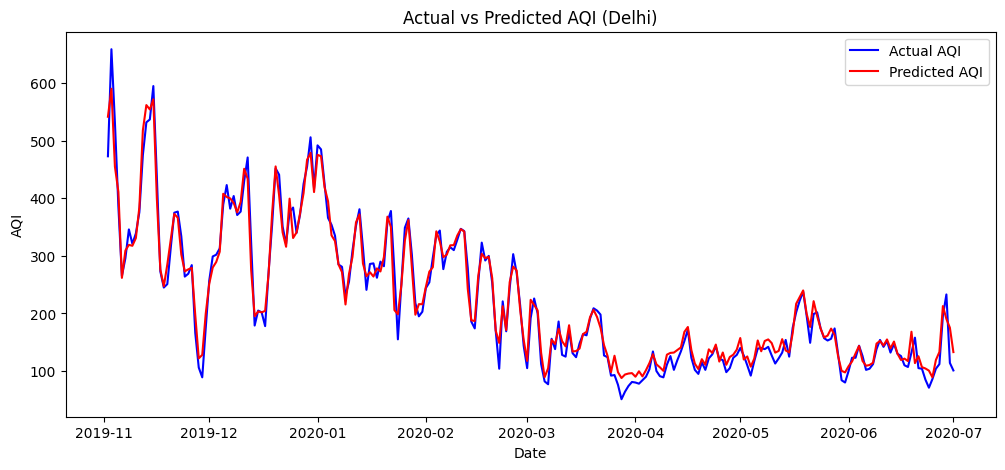

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label="Actual AQI", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted AQI", color="red")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.title("Actual vs Predicted AQI (Delhi)")
plt.legend()
plt.show()


2. Scatter Plot (Prediction Accuracy)

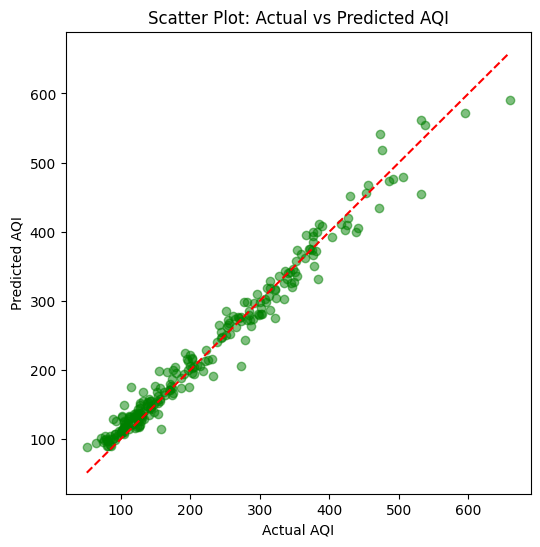

In [14]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Scatter Plot: Actual vs Predicted AQI")
plt.show()


3. Feature Importance (XGBoost)

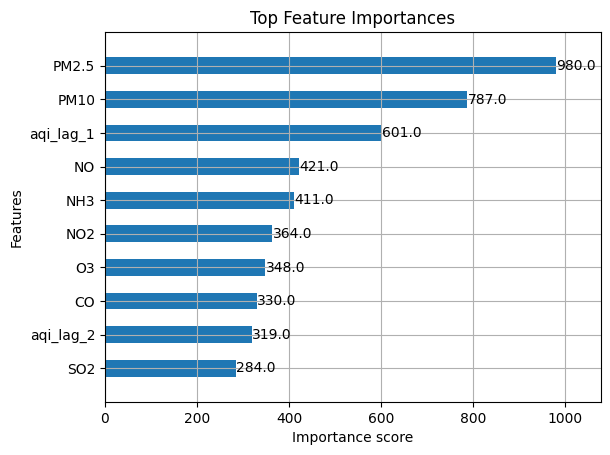

In [15]:
import xgboost as xgb

xgb.plot_importance(model, max_num_features=10, height=0.5)
plt.title("Top Feature Importances")
plt.show()


#PerceiverIO Implementation Plan

In [16]:
# # Step-1: Install & Imports

# !pip install git+https://github.com/lucidrains/perceiver-pytorch.git

# import torch
# from torch import nn, optim
# import matplotlib.pyplot as plt
# import numpy as np
# from perceiver_pytorch import PerceiverIO


In [17]:
# # Step-2: Prepare Data (from processed_delhi.csv)

# import pandas as pd

# # Load your processed dataset
# df_city = pd.read_csv("/content/data/processed_delhi.csv", index_col="Date", parse_dates=True)

# # Features (drop AQI as target)
# X = df_city.drop(columns=["AQI"]).values.astype(np.float32)
# y = df_city["AQI"].values.astype(np.float32)

# # Convert to Torch tensors
# X_tensor = torch.tensor(X)
# y_tensor = torch.tensor(y).unsqueeze(-1)   # [batch,1]

# # Train/test split (80/20)
# train_size = int(0.8 * len(X_tensor))
# X_train_t, X_test_t = X_tensor[:train_size], X_tensor[train_size:]
# y_train_t, y_test_t = y_tensor[:train_size], y_tensor[train_size:]

# print("Shapes:", X_train_t.shape, y_train_t.shape, X_test_t.shape)


In [18]:
# # Project features (e.g. 25) → 128 dimensions
# input_proj = nn.Linear(X_train_t.shape[1], 128)

# # PerceiverIO model
# model = PerceiverIO(
#     dim = 128,                # hidden dimension
#     queries_dim = 1,          # scalar output (AQI)
#     depth = 6,                # layers
#     num_latents = 64,
#     latent_dim = 128,
#     cross_heads = 1,
#     latent_heads = 8,
#     cross_dim_head = 64,
#     latent_dim_head = 64,
#     weight_tie_layers = False
# )

# # Optimizer + Loss
# loss_fn = nn.MSELoss()
# optimizer = optim.Adam(list(model.parameters()) + list(input_proj.parameters()), lr=1e-4)


In [22]:
# Single diagnostic cell: builds model and runs a tiny forward pass
!pip install -q git+https://github.com/lucidrains/perceiver-pytorch.git

import traceback
import torch
from torch import nn
import pandas as pd
from perceiver_pytorch import PerceiverIO

print("\n" + "="*60)
print("🚀 Python / Torch / PerceiverIO - Diagnostic Run")
print("="*60)

# -------------------- Load dataset --------------------
try:
    path = "/content/data/processed_delhi.csv"
    print(f"\n📂 Reading dataset from: {path}")
    df_city = pd.read_csv(path, index_col="Date", parse_dates=True)
    print("✅ Loaded CSV successfully")
    print(f"   Shape: {df_city.shape}")
except Exception as e:
    print("❌ Failed to load CSV:")
    traceback.print_exc()
    raise

# -------------------- Device setup --------------------
device = torch.device("cpu")
print(f"\n💻 Using device: {device}")

# -------------------- Prepare tensors --------------------
X = df_city.drop(columns=["AQI"]).values.astype(np.float32)
y = df_city["AQI"].values.astype(np.float32)

X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1).to(device)

train_size = int(0.8 * len(X_tensor))
X_train_t, X_test_t = X_tensor[:train_size], X_tensor[train_size:]
y_train_t, y_test_t = y_tensor[:train_size], y_tensor[train_size:]

print("\n📊 Data split shapes:")
print(f"   X_train: {X_train_t.shape}")
print(f"   y_train: {y_train_t.shape}")
print(f"   X_test : {X_test_t.shape}")

# -------------------- Build model --------------------
input_dim = X_train_t.shape[1]
proj_dim = 128
queries_dim = 1

input_proj = nn.Linear(input_dim, proj_dim).to(device)

model = PerceiverIO(
    dim=proj_dim,
    queries_dim=queries_dim,
    depth=3,
    num_latents=32,
    latent_dim=proj_dim,
    cross_heads=1,
    latent_heads=4,
    cross_dim_head=64,
    latent_dim_head=64,
    weight_tie_layers=False
).to(device)

learnable_queries_small = nn.Parameter(torch.randn(1, 1, queries_dim, device=device) * 0.01)
learnable_queries_proj  = nn.Parameter(torch.randn(1, 1, proj_dim, device=device) * 0.01)

print("\n🧩 Model + projection created")
print(f"   Input dim : {input_dim}")
print(f"   Proj dim  : {proj_dim}")

# -------------------- Forward test helper --------------------
def try_forward_once(model, x_batch, q_small, q_proj):
    """
    Try different forward calling styles for the model.
    Returns the name of the successful attempt and the output.
    """
    b = x_batch.shape[0]
    q1 = q_small.expand(b, -1, -1)
    q2 = q_proj.expand(b, -1, -1)
    exceptions = []

    calls = [
        ("pos_q1", lambda: model(x_batch, q1)),
        ("pos_q2", lambda: model(x_batch, q2)),
        ("kw_queries_q1", lambda: model(x_batch, queries=q1)),
        ("kw_queries_q2", lambda: model(x_batch, queries=q2)),
        ("kw_context_q1", lambda: model(x_batch, context=q1)),
        ("kw_context_q2", lambda: model(x_batch, context=q2)),
    ]

    for name, fn in calls:
        try:
            out = fn()
            return name, out
        except Exception as e:
            exceptions.append((name, e, traceback.format_exc()))

    print("\n❌ All call attempts failed. Showing last 3 exceptions:")
    for nm, ex, tb in exceptions[-3:]:
        print(f"\n--- Attempt: {nm} ---")
        print(tb)
    raise exceptions[-1][1]

# -------------------- Run tiny forward pass --------------------
batch = min(8, X_train_t.shape[0])
X_batch = X_train_t[:batch]
X_proj = input_proj(X_batch).unsqueeze(1)

print(f"\n🔍 Input projection shape: {X_proj.shape}")
print("▶️ Attempting forward pass with multiple query styles...")

try:
    attempt_name, output = try_forward_once(model, X_proj, learnable_queries_small, learnable_queries_proj)
    print(f"\n✅ Forward pass SUCCESS using attempt: {attempt_name}")
    print(f"   Output shape: {getattr(output, 'shape', None)}")
    try:
        arr = output.detach().cpu().numpy()
        print(f"   Output sample (first 8 values): {arr.ravel()[:8]}")
    except Exception:
        pass
except Exception:
    print("\n❌ Forward attempts all failed. See error above.")
    raise


  Preparing metadata (setup.py) ... done

🚀 Python / Torch / PerceiverIO - Diagnostic Run

📂 Reading dataset from: /content/data/processed_delhi.csv
✅ Loaded CSV successfully
   Shape: (1213, 26)

💻 Using device: cpu

📊 Data split shapes:
   X_train: torch.Size([970, 25])
   y_train: torch.Size([970, 1])
   X_test : torch.Size([243, 25])

🧩 Model + projection created
   Input dim : 25
   Proj dim  : 128

🔍 Input projection shape: torch.Size([8, 1, 128])
▶️ Attempting forward pass with multiple query styles...

✅ Forward pass SUCCESS using attempt: kw_queries_q1
   Output shape: torch.Size([8, 1, 1])
   Output sample (first 8 values): [-0.12541443 -0.10441411 -0.10276806 -0.1130937  -0.12803864 -0.12869528
 -0.09415485 -0.12013292]


In [20]:
# Cell 1: install + imports + safe forward wrapper
!pip install -q git+https://github.com/lucidrains/perceiver-pytorch.git

import inspect, traceback, os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from perceiver_pytorch import PerceiverIO

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Load processed CSV path (ensure this path exists from your preprocessing step)
DATA_PATH = "/content/data/processed_delhi.csv"
assert os.path.exists(DATA_PATH), f"{DATA_PATH} not found. Run preprocessing cell first."

# Safe forward helper (tries the common call styles)
def perceiver_forward_try_variants(model, x_batch, q_small, q_proj):
    b = x_batch.shape[0]
    q1 = q_small.expand(b, -1, -1)
    q2 = q_proj.expand(b, -1, -1)
    exceptions = []

    attempts = [
        ("kw_queries_q1", lambda: model(x_batch, **{'queries': q1})),
        ("pos_q1", lambda: model(x_batch, q1)),
        ("kw_queries_q2", lambda: model(x_batch, **{'queries': q2})),
        ("pos_q2", lambda: model(x_batch, q2)),
        ("kw_context_q1", lambda: model(x_batch, **{'context': q1})),
        ("kw_context_q2", lambda: model(x_batch, **{'context': q2})),
    ]

    for name, fn in attempts:
        try:
            return fn()
        except Exception as e:
            exceptions.append((name, e, traceback.format_exc()))

    print("All call attempts failed. Last exceptions:")
    for nm, ex, tb in exceptions[-3:]:
        print("--- Attempt:", nm, "---")
        print(tb)
    raise exceptions[-1][1]


  Preparing metadata (setup.py) ... done
Device: cpu


In [21]:
# Cell 2: load data, build model, projection and learnable queries, DataLoader
df_city = pd.read_csv(DATA_PATH, index_col="Date", parse_dates=True)
print("Loaded processed CSV shape:", df_city.shape)

# Prepare tensors
X = df_city.drop(columns=["AQI"]).values.astype(np.float32)
y = df_city["AQI"].values.astype(np.float32)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# Split
train_size = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]
print("Shapes -> X_train:", X_train.shape, "X_test:", X_test.shape)

# Hyperparams
proj_dim = 128
queries_dim = 1
batch_size = 64
epochs = 30
lr = 1e-4

# Model parts
input_proj = nn.Linear(X_train.shape[1], proj_dim).to(device)

model = PerceiverIO(
    dim = proj_dim,
    queries_dim = queries_dim,
    depth = 6,
    num_latents = 64,
    latent_dim = proj_dim,
    cross_heads = 1,
    latent_heads = 8,
    cross_dim_head = 64,
    latent_dim_head = 64,
    weight_tie_layers = False
).to(device)

# Learnable queries (two variants)
learnable_queries_small = nn.Parameter(torch.randn(1, 1, queries_dim, device=device) * 0.01)
learnable_queries_proj  = nn.Parameter(torch.randn(1, 1, proj_dim, device=device) * 0.01)

# DataLoaders
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Loss & optimizer
loss_fn = nn.MSELoss()
optim_params = list(model.parameters()) + list(input_proj.parameters()) + [learnable_queries_small, learnable_queries_proj]
optimizer = optim.Adam(optim_params, lr=lr)

print("Model, projection and dataloaders ready.")


Loaded processed CSV shape: (1213, 26)
Shapes -> X_train: torch.Size([970, 25]) X_test: torch.Size([243, 25])
Model, projection and dataloaders ready.


Epoch 1/30  Loss: 77881.612146
Epoch 4/30  Loss: 76339.010567
Epoch 9/30  Loss: 73026.300161
Epoch 14/30  Loss: 68535.087274
Epoch 19/30  Loss: 63049.018976
Epoch 24/30  Loss: 56786.423180
Epoch 29/30  Loss: 50057.612838


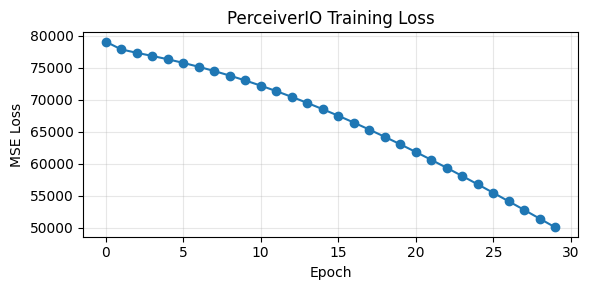

Test RMSE: 196.8864   R2: -1.6439


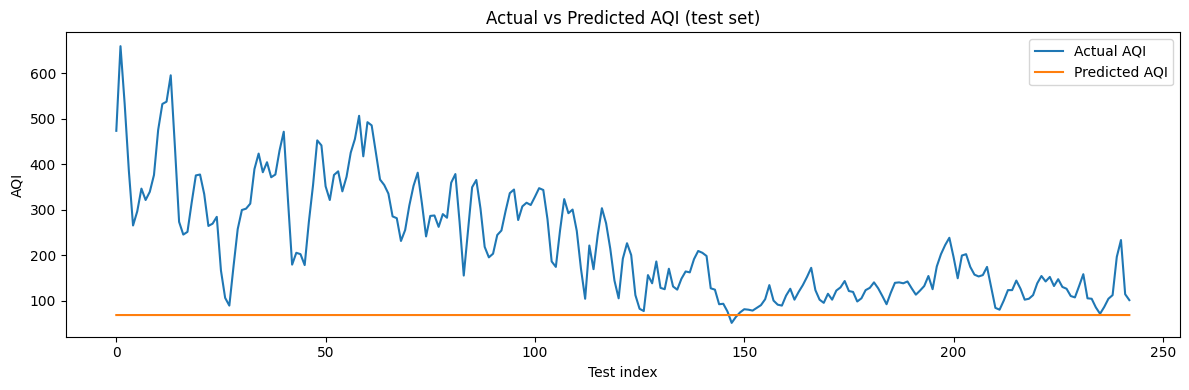

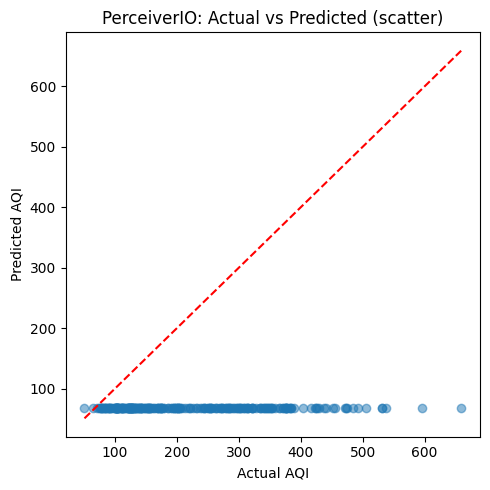


Saved files:
/content/perceiver_train_loss.png
/content/perceiver_actual_vs_pred.png
/content/perceiver_scatter.png


In [27]:
# Cell 3: training loop, evaluation, plots
model.train()
train_losses = []

for epoch in range(epochs):
    epoch_loss = 0.0
    n_samples = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).squeeze()
        optimizer.zero_grad()
        xb_proj = input_proj(xb).unsqueeze(1)   # [B,1,proj_dim]
        out = perceiver_forward_try_variants(model, xb_proj, learnable_queries_small, learnable_queries_proj)
        if out.dim() > 1:
            out = out.view(out.shape[0], -1)[:,0]
        else:
            out = out.squeeze()
        loss = loss_fn(out, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += float(loss.item()) * xb.size(0)
        n_samples += xb.size(0)
    train_losses.append(epoch_loss / n_samples)
    if (epoch+1) % 5 == 0 or epoch == 1 or epoch == epochs:
        print(f"Epoch {epoch}/{epochs}  Loss: {train_losses[-1]:.6f}")

# Training loss plot
plt.figure(figsize=(6,3))
plt.plot(train_losses, marker='o')
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.title("PerceiverIO Training Loss")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("/content/perceiver_train_loss.png", dpi=200)
plt.show()

# --- Evaluation ---
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device).squeeze()
        xb_proj = input_proj(xb).unsqueeze(1)
        out = perceiver_forward_try_variants(model, xb_proj, learnable_queries_small, learnable_queries_proj)
        if out.dim() > 1:
            out = out.view(out.shape[0], -1)[:,0]
        else:
            out = out.squeeze()
        y_true.append(yb.cpu().numpy())
        y_pred.append(out.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

rmse = np.sqrt(np.mean((y_true - y_pred)**2))
from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)
print(f"Test RMSE: {rmse:.4f}   R2: {r2:.4f}")

# Line plot
plt.figure(figsize=(12,4))
plt.plot(y_true, label="Actual AQI")
plt.plot(y_pred, label="Predicted AQI")
plt.legend(); plt.title("Actual vs Predicted AQI (test set)")
plt.xlabel("Test index"); plt.ylabel("AQI")
plt.tight_layout()
plt.savefig("/content/perceiver_actual_vs_pred.png", dpi=200)
plt.show()

# Scatter plot
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, alpha=0.5)
mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([mn,mx],[mn,mx],'r--')
plt.xlabel("Actual AQI"); plt.ylabel("Predicted AQI")
plt.title("PerceiverIO: Actual vs Predicted (scatter)")
plt.tight_layout()
plt.savefig("/content/perceiver_scatter.png", dpi=200)
plt.show()

print("\nSaved files:")
print("/content/perceiver_train_loss.png")
print("/content/perceiver_actual_vs_pred.png")
print("/content/perceiver_scatter.png")


# 1 Prereqs & Imports (run once)

In [28]:
# Cell A: Install (if needed) and imports
!pip install -q scikit-learn joblib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# sklearn / joblib / torch
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

print("libs loaded")


libs loaded


# Load processed dataset & basic split (time-ordered)

In [30]:
# Cell B: Load the processed CSV
DATA_PATH = "/content/data/processed_delhi.csv"
df = pd.read_csv(DATA_PATH, index_col="Date", parse_dates=True)
df.head()

# features and target
FEATURES = [c for c in df.columns if c != "AQI"]
X = df[FEATURES].values      # shape (T, F)
y = df["AQI"].values         # shape (T,)

# time-ordered split 80/20
n = len(df)
train_end = int(0.8 * n)
print("Rows:", n, "Train_end index:", train_end)

X_train_full = X[:train_end]
y_train_full = y[:train_end]
X_test_full  = X[train_end:]
y_test_full  = y[train_end:]

print("X_train shape:", X_train_full.shape, "X_test shape:", X_test_full.shape)


Rows: 1213 Train_end index: 970
X_train shape: (970, 25) X_test shape: (243, 25)


# Baseline A — RandomForest (tabular)

RandomForest -> RMSE: 365.3166 R2: 0.9751 MAE: 13.7869
Saved rf model and scaler


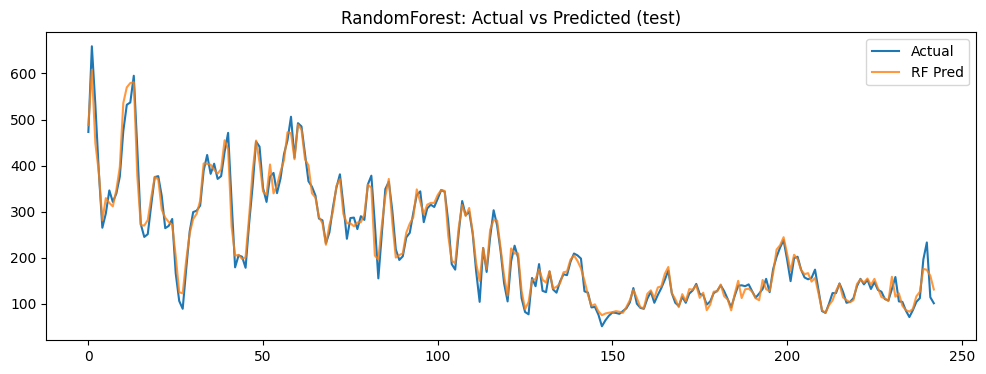

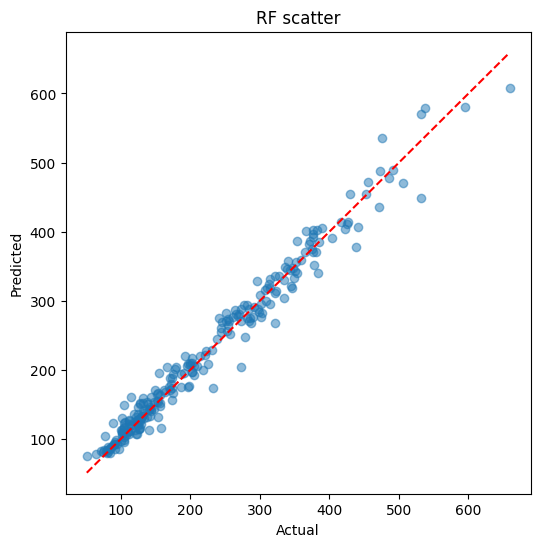

In [31]:
# Cell C: Train & evaluate RandomForest
# 1. Scale features (optional but ok)
scaler_rf = StandardScaler()
X_train_scaled = scaler_rf.fit_transform(X_train_full)
X_test_scaled  = scaler_rf.transform(X_test_full)

# 2. Train RF
rf = RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train_full)

# 3. Predict & metrics
y_pred_rf = rf.predict(X_test_scaled)
rmse_rf = mean_squared_error(y_test_full, y_pred_rf)
r2_rf   = r2_score(y_test_full, y_pred_rf)
mae_rf  = mean_absolute_error(y_test_full, y_pred_rf)

print("RandomForest -> RMSE:", round(rmse_rf,4), "R2:", round(r2_rf,4), "MAE:", round(mae_rf,4))

# 4. Save model + scaler
joblib.dump(rf, "/content/rf_aqi_model.joblib")
joblib.dump(scaler_rf, "/content/rf_scaler.joblib")
print("Saved rf model and scaler")

# 5. Quick plots (actual vs predicted)
plt.figure(figsize=(12,4))
plt.plot(y_test_full, label="Actual")
plt.plot(y_pred_rf, label="RF Pred", alpha=0.8)
plt.legend(); plt.title("RandomForest: Actual vs Predicted (test)")
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test_full, y_pred_rf, alpha=0.5)
mn, mx = min(min(y_test_full), min(y_pred_rf)), max(max(y_test_full), max(y_pred_rf))
plt.plot([mn,mx],[mn,mx],'r--'); plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("RF scatter")
plt.show()


# Baseline B — LSTM (sequence model)

In [32]:
# Prepare windowed dataset

In [33]:
# Cell D: Create windows for LSTM
seq_len = 30   # use last 30 days to predict next day (tune this)
# fit scaler on train rows only
scaler = StandardScaler().fit(X[:train_end])
X_scaled = scaler.transform(X)   # scale all using train-fit scaler

# create sliding windows and record target index
X_seqs = []
y_seqs = []
target_idx = []
T = len(X_scaled)
for i in range(0, T - seq_len):
    X_seqs.append(X_scaled[i:i+seq_len])       # (seq_len, features)
    y_seqs.append(y[i+seq_len])               # target is next day AQI
    target_idx.append(i + seq_len)

X_seqs = np.stack(X_seqs)   # shape (N_windows, seq_len, F)
y_seqs = np.array(y_seqs)   # shape (N_windows,)
target_idx = np.array(target_idx)

print("Created windows:", X_seqs.shape, y_seqs.shape)
# split windows by target index into train/test sets
train_mask = target_idx < train_end
test_mask  = target_idx >= train_end

X_train = X_seqs[train_mask]
y_train = y_seqs[train_mask]
X_test  = X_seqs[test_mask]
y_test  = y_seqs[test_mask]

print("LSTM windows -> train:", X_train.shape, y_train.shape, "test:", X_test.shape, y_test.shape)


Created windows: (1183, 30, 25) (1183,)
LSTM windows -> train: (940, 30, 25) (940,) test: (243, 30, 25) (243,)


In [34]:
# 4.2 PyTorch Dataset & Model

In [35]:
# Cell E: Dataset, model, training helpers
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = TimeSeriesDataset(X_train, y_train)
test_ds  = TimeSeriesDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# LSTM model
class LSTMReg(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        # x: [B, seq_len, features]
        out, _ = self.lstm(x)           # out: [B, seq_len, hidden]
        h = out[:, -1, :]               # take last time step
        return self.fc(h).squeeze(-1)   # [B]

input_size = X_train.shape[2]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lstm = LSTMReg(input_size=input_size, hidden_size=128).to(device)
print("LSTM on device:", device)


LSTM on device: cuda


In [36]:
# 4.3 Train LSTM

In [42]:
# Cell F: Train LSTM
epochs = 40
lr = 1e-3
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=lr)
criterion = nn.MSELoss()

train_losses = []
for epoch in range(epochs):
    model_lstm.train()
    running_loss = 0.0
    n = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model_lstm(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        n += xb.size(0)
    train_loss = running_loss / n
    train_losses.append(train_loss)
    if (epoch+1) % 5 == 0 or epoch==0:
        print(f"Epoch {epoch+1}/{epochs}  Train MSE: {train_loss:.4f}")


Epoch 1/40  Train MSE: 13370.7846
Epoch 5/40  Train MSE: 6362.3392
Epoch 10/40  Train MSE: 3129.0183
Epoch 15/40  Train MSE: 2294.6494
Epoch 20/40  Train MSE: 1899.7880
Epoch 25/40  Train MSE: 1700.8763
Epoch 30/40  Train MSE: 1643.5820
Epoch 35/40  Train MSE: 1535.7397
Epoch 40/40  Train MSE: 1436.4263


In [43]:
# 4.4 Evaluate LSTM

LSTM -> RMSE: 1471.6772 R2: 0.8996 MAE: 28.317


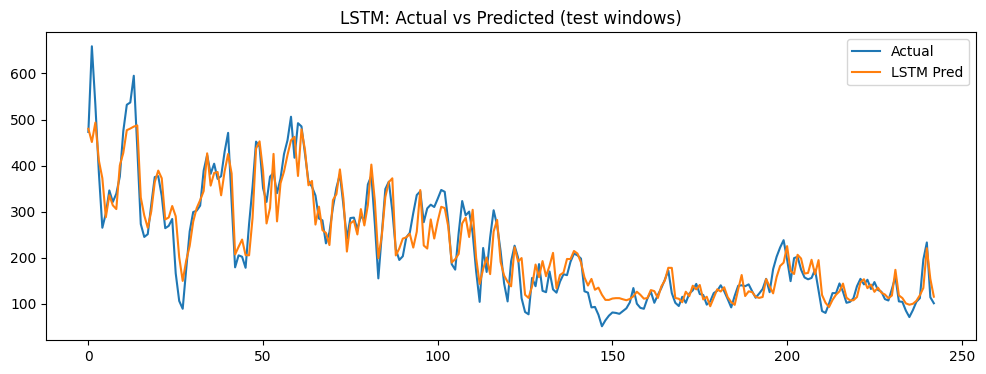

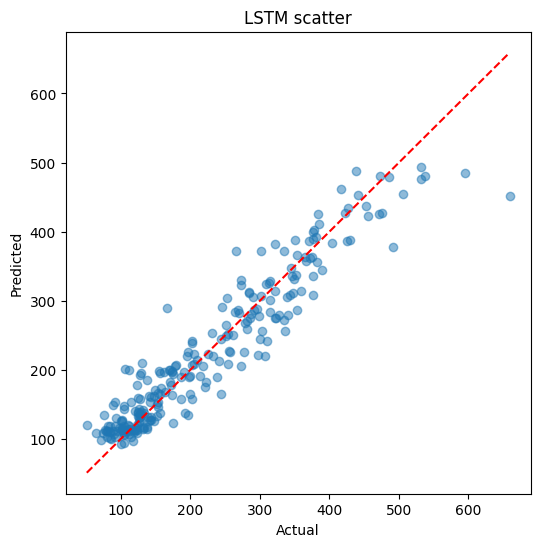

Saved LSTM weights to /content/lstm_aqi.pth


In [44]:
# Cell G: Evaluate LSTM on test windows
model_lstm.eval()
preds = []
truths = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model_lstm(xb).cpu().numpy()
        preds.append(out)
        truths.append(yb.numpy())
preds = np.concatenate(preds)
truths = np.concatenate(truths)

rmse_lstm = mean_squared_error(truths, preds)
r2_lstm = r2_score(truths, preds)
mae_lstm = mean_absolute_error(truths, preds)
print("LSTM -> RMSE:", round(rmse_lstm,4), "R2:", round(r2_lstm,4), "MAE:", round(mae_lstm,4))

# plots
plt.figure(figsize=(12,4))
plt.plot(truths, label="Actual")
plt.plot(preds, label="LSTM Pred")
plt.legend(); plt.title("LSTM: Actual vs Predicted (test windows)")
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(truths, preds, alpha=0.5)
mn, mx = min(truths.min(), preds.min()), max(truths.max(), preds.max())
plt.plot([mn,mx],[mn,mx],'r--')
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("LSTM scatter")
plt.show()

# Save model
torch.save(model_lstm.state_dict(), "/content/lstm_aqi.pth")
print("Saved LSTM weights to /content/lstm_aqi.pth")


In [45]:
# 5) Compare results & save metrics table

In [46]:
# Cell H: Compare RF and LSTM results
# RF results available from earlier cell: y_pred_rf, y_test_full
# LSTM results: preds, truths (on windows) -> these correspond to test windows

# For RF we used samples per-day; for LSTM windows we predicted next-day for windowed test.
# Print metrics again for clarity:
print("RandomForest -> RMSE:", round(rmse_rf,4), "R2:", round(r2_rf,4), "MAE:", round(mae_rf,4))
print("LSTM         -> RMSE:", round(rmse_lstm,4), "R2:", round(r2_lstm,4), "MAE:", round(mae_lstm,4))

# Save a simple CSV for your report
metrics = pd.DataFrame({
    "model": ["RandomForest", "LSTM"],
    "rmse": [rmse_rf, rmse_lstm],
    "r2": [r2_rf, r2_lstm],
    "mae": [mae_rf, mae_lstm]
})
metrics.to_csv("/content/model_comparison_metrics.csv", index=False)
print("Saved metrics:", "/content/model_comparison_metrics.csv")
metrics


RandomForest -> RMSE: 365.3166 R2: 0.9751 MAE: 13.7869
LSTM         -> RMSE: 1471.6772 R2: 0.8996 MAE: 28.317
Saved metrics: /content/model_comparison_metrics.csv


,model,rmse,r2,mae
0,RandomForest,365.316565,0.975083,13.786860
1,LSTM,1471.677246,0.899623,28.317032


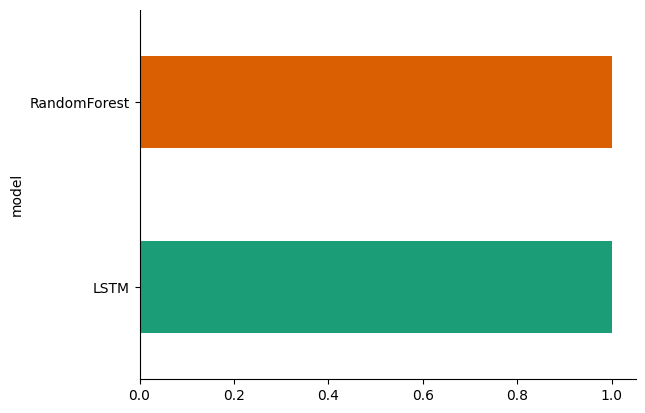

In [47]:
# @title model

from matplotlib import pyplot as plt
import seaborn as sns
metrics.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

/tmp/ipython-input-780909343.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(metrics, x='mae', y='model', inner='stick', palette='Dark2')


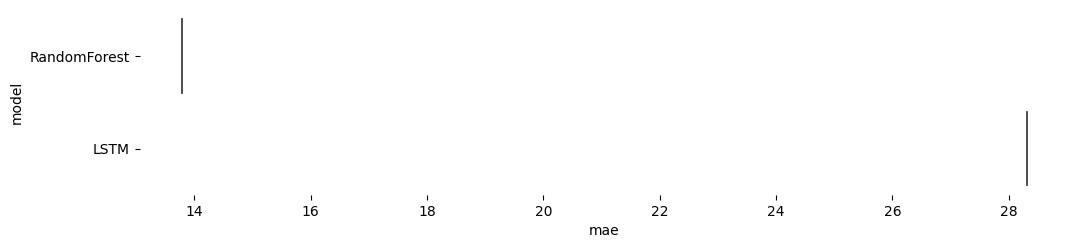

In [48]:
# @title model vs mae

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(metrics['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(metrics, x='mae', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

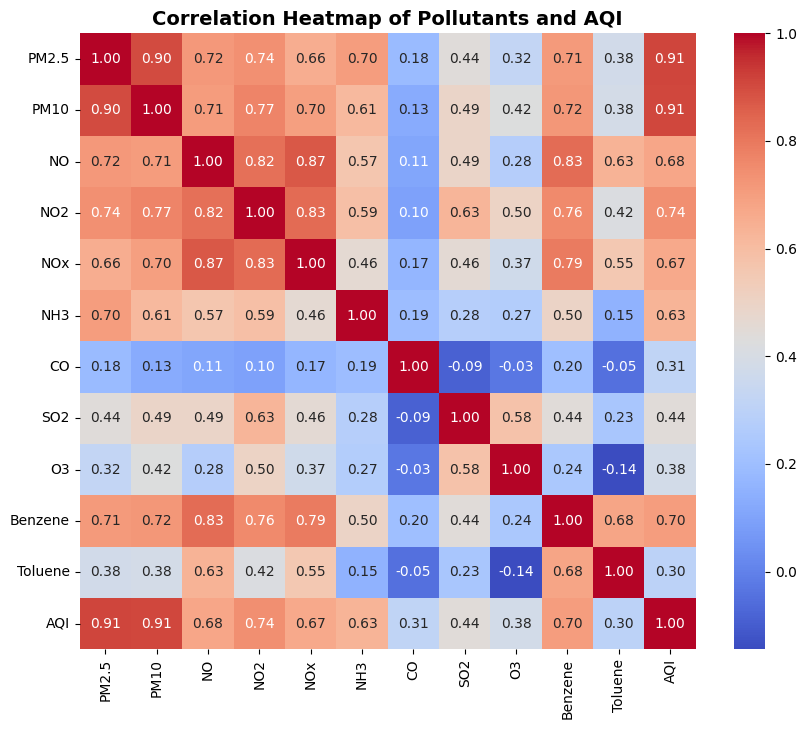

In [49]:
# Cell: Correlation Heatmap (without Xylene)
import seaborn as sns
import matplotlib.pyplot as plt

# Select pollutants (excluding Xylene) + AQI
pollutants = ["PM2.5","PM10","NO","NO2","NOx","NH3","CO","SO2","O3","Benzene","Toluene","AQI"]
df_pollutants = df_city[pollutants]

# Compute correlation matrix
corr_matrix = df_pollutants.corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Heatmap of Pollutants and AQI", fontsize=14, fontweight="bold")
plt.show()
